In [1]:
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from alpha_vantage.timeseries import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.regularizers import L1L2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import seaborn as sns
import backtrader as bt

## 1.数据收集

In [2]:
# 定义 API 密钥
api_key = 'Y5BPDVZVLTE20UG5'

# 初始化 Alpha Vantage TimeSeries 类
ts = TimeSeries(key=api_key, output_format='pandas')

# 定义股票符号
stocks = ['NVDA', 'AMD', 'INTC']

# 初始化一个空的 DataFrame 用于存储所有数据
all_stock_data = pd.DataFrame()

# 获取当前日期并计算5年前的日期
current_date = datetime.now()
five_years_ago = current_date.replace(year=current_date.year - 5)

# 为每个股票获取数据并合并
for stock in stocks:
    data, meta_data = ts.get_daily(symbol=stock, outputsize='full')
    # 筛选最近5年的数据
    data = data[data.index >= five_years_ago.strftime('%Y-%m-%d')]
    # 为股票数据添加列
    data['Stock'] = stock
    # 与主 DataFrame 合并
    all_stock_data = pd.concat([all_stock_data, data], axis=0)

# 重置最终 DataFrame 的索引
all_stock_data.reset_index(inplace=True)

# 现在 all_stock_data DataFrame 包含了每家公司的股票数据


In [3]:
all_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3774 non-null   datetime64[ns]
 1   1. open    3774 non-null   float64       
 2   2. high    3774 non-null   float64       
 3   3. low     3774 non-null   float64       
 4   4. close   3774 non-null   float64       
 5   5. volume  3774 non-null   float64       
 6   Stock      3774 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 206.5+ KB


In [4]:
all_stock_data.head(5)

,date,1. open,2. high,3. low,4. close,5. volume,Stock
0,2024-01-30,629.00,634.93,622.60,627.74,41073530.0,NVDA
1,2024-01-29,612.32,624.89,609.07,624.65,34873298.0,NVDA
2,2024-01-26,609.60,617.83,605.73,610.31,39030859.0,NVDA
3,2024-01-25,623.50,627.19,608.50,616.17,48277684.0,NVDA
4,2024-01-24,603.04,628.49,599.38,613.62,55706870.0,NVDA


## 2.基本统计分析

In [5]:
all_stock_data.describe()

,date,1. open,2. high,3. low,4. close,5. volume
count,3774,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03
mean,2021-07-29 19:29:51.414944256,148.730887,151.336277,146.071606,148.823218,4.289304e+07
min,2019-01-31 00:00:00,21.350000,22.090000,21.040000,22.010000,2.447088e+06
25%,2020-04-30 00:00:00,49.615000,50.280000,48.982500,49.705000,2.164998e+07
50%,2021-07-29 12:00:00,82.975000,84.477500,81.472500,82.755000,3.857676e+07
75%,2022-10-27 00:00:00,182.900000,186.727500,180.322500,183.187500,5.570638e+07
max,2024-01-30 00:00:00,834.140000,835.000000,814.010000,827.940000,2.253687e+08
std,NaN,154.307301,156.754167,151.651857,154.373376,2.864196e+07


In [6]:
all_stock_data['Stock'].value_counts()

Stock
NVDA    1258
AMD     1258
INTC    1258
Name: count, dtype: int64

## 3.特征工程方案

In [7]:
# 首先按照股票名称和日期进行排序
all_stock_data.sort_values(by=['Stock', 'date'], inplace=True)


In [8]:
# 计算移动平均线
def calculate_moving_average(data, window_size):
    return data['4. close'].rolling(window=window_size).mean()

# 计算RSI
def calculate_rsi(data, window_size=14):
    delta = data['4. close'].diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    ma_up, ma_down = up.rolling(window_size).mean(), down.rolling(window_size).mean()
    rsi = ma_up / (ma_up + ma_down) * 100
    return rsi

# 修改布林带计算函数，使其返回两个单独的Series
def calculate_bollinger_bands(data, window_size=20, num_std_dev=2):
    rolling_mean = data.rolling(window=window_size).mean()
    rolling_std = data.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band

In [9]:
# 对每个股票分别应用计算函数，并重置索引
ma_20 = all_stock_data.groupby('Stock')['4. close'].apply(lambda x: x.rolling(window=20).mean()).reset_index(level=0, drop=True)
rsi = all_stock_data.groupby('Stock').apply(lambda x: calculate_rsi(x)).reset_index(level=0, drop=True)

# 应用布林带计算
upper_band, lower_band = zip(*all_stock_data.groupby('Stock')['4. close'].apply(calculate_bollinger_bands))
upper_band = pd.concat(upper_band).reset_index(level=0, drop=True)
lower_band = pd.concat(lower_band).reset_index(level=0, drop=True)

# 将计算结果分配给原始DataFrame的新列
all_stock_data['MA_20'] = ma_20
all_stock_data['RSI'] = rsi
all_stock_data['Upper_Band'] = upper_band
all_stock_data['Lower_Band'] = lower_band


In [10]:
# 展示新数据
all_stock_data.head()

,date,1. open,2. high,3. low,4. close,5. volume,Stock,MA_20,RSI,Upper_Band,Lower_Band
2515,2019-01-31,23.02,25.14,22.83,24.41,182575629.0,AMD,NaN,NaN,50.643495,43.507505
2514,2019-02-01,24.61,24.84,24.07,24.51,105356175.0,AMD,NaN,NaN,50.705615,44.178385
2513,2019-02-04,24.43,24.66,24.07,24.13,70843958.0,AMD,NaN,NaN,50.818721,44.720279
2512,2019-02-05,23.42,23.86,22.98,23.31,122226034.0,AMD,NaN,NaN,50.785016,45.464984
2511,2019-02-06,23.63,24.14,23.22,23.26,78684325.0,AMD,NaN,NaN,50.970032,45.374968


In [11]:
all_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3774 entries, 2515 to 0
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3774 non-null   datetime64[ns]
 1   1. open     3774 non-null   float64       
 2   2. high     3774 non-null   float64       
 3   3. low      3774 non-null   float64       
 4   4. close    3774 non-null   float64       
 5   5. volume   3774 non-null   float64       
 6   Stock       3774 non-null   object        
 7   MA_20       3717 non-null   float64       
 8   RSI         3732 non-null   float64       
 9   Upper_Band  3717 non-null   float64       
 10  Lower_Band  3717 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 353.8+ KB


### 3.1 计算 Daily return

In [12]:
# Filter the DataFrame for Apple stock and sort by date
NVDA = all_stock_data[all_stock_data['Stock'] == 'NVDA'].sort_values(by='date')
AMD = all_stock_data[all_stock_data['Stock'] == 'AMD'].sort_values(by='date')
INTC = all_stock_data[all_stock_data['Stock'] == 'INTC'].sort_values(by='date')

In [13]:
# Calculate daily returns for Apple
# The daily return is calculated by taking the difference of closing prices and dividing by the closing price of the previous day.
NVDA['daily_return'] = NVDA['4. close'].pct_change()
AMD['daily_return'] = AMD['4. close'].pct_change()
INTC['daily_return'] = INTC['4. close'].pct_change()


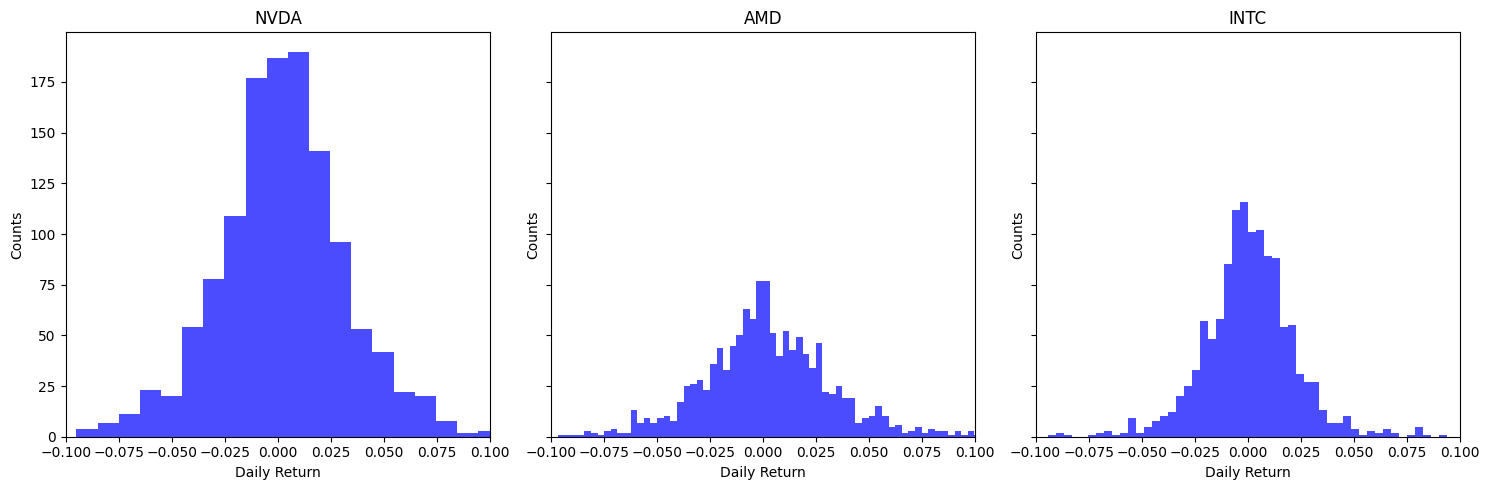

In [14]:
# We'll use 100 bins for each histogram to get a similar look and feel as the provided screenshot.

# Define the figure for plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the array for easy iteration

# List of companies and their data
companies_data = [NVDA, AMD, INTC]
company_names = ['NVDA', 'AMD', 'INTC']

# Plot histograms of daily returns for each company with adjusted parameters
for ax, data, name in zip(axs, companies_data, company_names):
    # Plot the histogram with 100 bins and density=False to show counts
    ax.hist(data['daily_return'].dropna(), bins=100, color='blue', alpha=0.7, density=False)
    ax.set_title(f'{name}')
    ax.set_xlabel('Daily Return')
    ax.set_ylabel('Counts')
    # Set the limits for x-axis to normalize across all histograms
    ax.set_xlim(-0.1, 0.1)

plt.tight_layout()
plt.show()


In [15]:
# We will ignore the index to allow for a continuous index in the new DataFrame.
combined_data = pd.concat([NVDA, AMD, INTC], ignore_index=True)


In [16]:
stock_names = ['NVDA', 'AMD', 'INTC']

# 计算每只股票的50日移动平均线并添加到DataFrame
for stock_name in stock_names:
    stock_data = combined_data[combined_data['Stock'] == stock_name]
    combined_data.loc[combined_data['Stock'] == stock_name, 'MA_50'] = stock_data['4. close'].rolling(window=50).mean()

# 现在 combined_data 中包含了新的 MA_50 列


In [17]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3774 non-null   datetime64[ns]
 1   1. open       3774 non-null   float64       
 2   2. high       3774 non-null   float64       
 3   3. low        3774 non-null   float64       
 4   4. close      3774 non-null   float64       
 5   5. volume     3774 non-null   float64       
 6   Stock         3774 non-null   object        
 7   MA_20         3717 non-null   float64       
 8   RSI           3732 non-null   float64       
 9   Upper_Band    3717 non-null   float64       
 10  Lower_Band    3717 non-null   float64       
 11  daily_return  3771 non-null   float64       
 12  MA_50         3627 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 383.4+ KB


In [18]:
combined_data.describe()

,date,1. open,2. high,3. low,4. close,5. volume,MA_20,RSI,Upper_Band,Lower_Band,daily_return,MA_50
count,3774,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03,3717.000000,3732.000000,3717.000000,3717.000000,3771.000000,3627.000000
mean,2021-07-29 19:29:51.414944,148.730887,151.336277,146.071606,148.823218,4.289304e+07,148.481046,53.338046,165.570989,131.391103,0.001509,148.312556
min,2019-01-31 00:00:00,21.350000,22.090000,21.040000,22.010000,2.447088e+06,23.378000,4.297090,24.611393,-176.325710,-0.752233,24.676200
25%,2020-04-30 00:00:00,49.615000,50.280000,48.982500,49.705000,2.164998e+07,50.012000,41.089227,53.295759,45.166699,-0.013899,49.999800
50%,2021-07-29 12:00:00,82.975000,84.477500,81.472500,82.755000,3.857676e+07,82.098500,53.573933,91.311302,74.386833,0.001021,83.336600
75%,2022-10-27 00:00:00,182.900000,186.727500,180.322500,183.187500,5.570638e+07,181.136000,66.118851,199.491826,159.859299,0.016735,180.530500
max,2024-01-30 00:00:00,834.140000,835.000000,814.010000,827.940000,2.253687e+08,786.421000,97.415135,1182.754889,728.781800,0.243696,699.710800
std,NaN,154.307301,156.754167,151.651857,154.373376,2.864196e+07,152.219886,17.454872,175.251639,136.718953,0.032587,149.887677


In [19]:
# 使用前一个有效值填充MA_20, RSI, Upper_Band, Lower_Band
combined_data['MA_20'].fillna(method='ffill', inplace=True)
combined_data['RSI'].fillna(method='ffill', inplace=True)
combined_data['Upper_Band'].fillna(method='ffill', inplace=True)
combined_data['Lower_Band'].fillna(method='ffill', inplace=True)
combined_data['MA_50'].fillna(method='ffill', inplace=True)

# 将daily_return的缺失值设置为0
combined_data['daily_return'].fillna(0, inplace=True)


/var/folders/c9/r0x018d10sgb2j79vcspqf8h0000gn/T/ipykernel_22658/387435716.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['MA_20'].fillna(method='ffill', inplace=True)
/var/folders/c9/r0x018d10sgb2j79vcspqf8h0000gn/T/ipykernel_22658/387435716.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['RSI'].fillna(method='ffill', inplace=True)
/var/folders/c9/r0x018d10sgb2j79vcspqf8h0000gn/T/ipykernel_22658/387435716.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['Upper_Band'].fillna(method='ffill', inplace=True)
/var/folders/c9/r0x018d10sgb2j79vcspqf8h0000gn/T/ipykernel_22658/387435716.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future vers

In [20]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3774 non-null   datetime64[ns]
 1   1. open       3774 non-null   float64       
 2   2. high       3774 non-null   float64       
 3   3. low        3774 non-null   float64       
 4   4. close      3774 non-null   float64       
 5   5. volume     3774 non-null   float64       
 6   Stock         3774 non-null   object        
 7   MA_20         3755 non-null   float64       
 8   RSI           3760 non-null   float64       
 9   Upper_Band    3774 non-null   float64       
 10  Lower_Band    3774 non-null   float64       
 11  daily_return  3774 non-null   float64       
 12  MA_50         3725 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 383.4+ KB


In [21]:
combined_data= combined_data.dropna()


In [22]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3725 entries, 49 to 3773
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3725 non-null   datetime64[ns]
 1   1. open       3725 non-null   float64       
 2   2. high       3725 non-null   float64       
 3   3. low        3725 non-null   float64       
 4   4. close      3725 non-null   float64       
 5   5. volume     3725 non-null   float64       
 6   Stock         3725 non-null   object        
 7   MA_20         3725 non-null   float64       
 8   RSI           3725 non-null   float64       
 9   Upper_Band    3725 non-null   float64       
 10  Lower_Band    3725 non-null   float64       
 11  daily_return  3725 non-null   float64       
 12  MA_50         3725 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 407.4+ KB


In [23]:
combined_data.to_csv('week7-8.csv', index=False)

In [24]:
# 计算每家公司的平均收盘价
average_close = combined_data.groupby('Stock')['4. close'].mean()
print("平均收盘价:\n", average_close)

# 计算每家公司的平均交易量
average_volume = combined_data.groupby('Stock')['5. volume'].mean()
print("平均交易量:\n", average_volume)

# 计算每家公司的日收益率的标准差
std_daily_return = combined_data.groupby('Stock')['daily_return'].std()
print("日收益率的标准差:\n", std_daily_return)


平均收盘价:
 Stock
AMD      80.261069
INTC     46.930270
NVDA    325.540008
Name: 4. close, dtype: float64
平均交易量:
 Stock
AMD     6.618538e+07
INTC    3.290535e+07
NVDA    3.020200e+07
Name: 5. volume, dtype: float64
日收益率的标准差:
 Stock
AMD     0.033029
INTC    0.024581
NVDA    0.039106
Name: daily_return, dtype: float64


## 4.可视化分析

### 4.1 绘制价格走势图和成交量图表

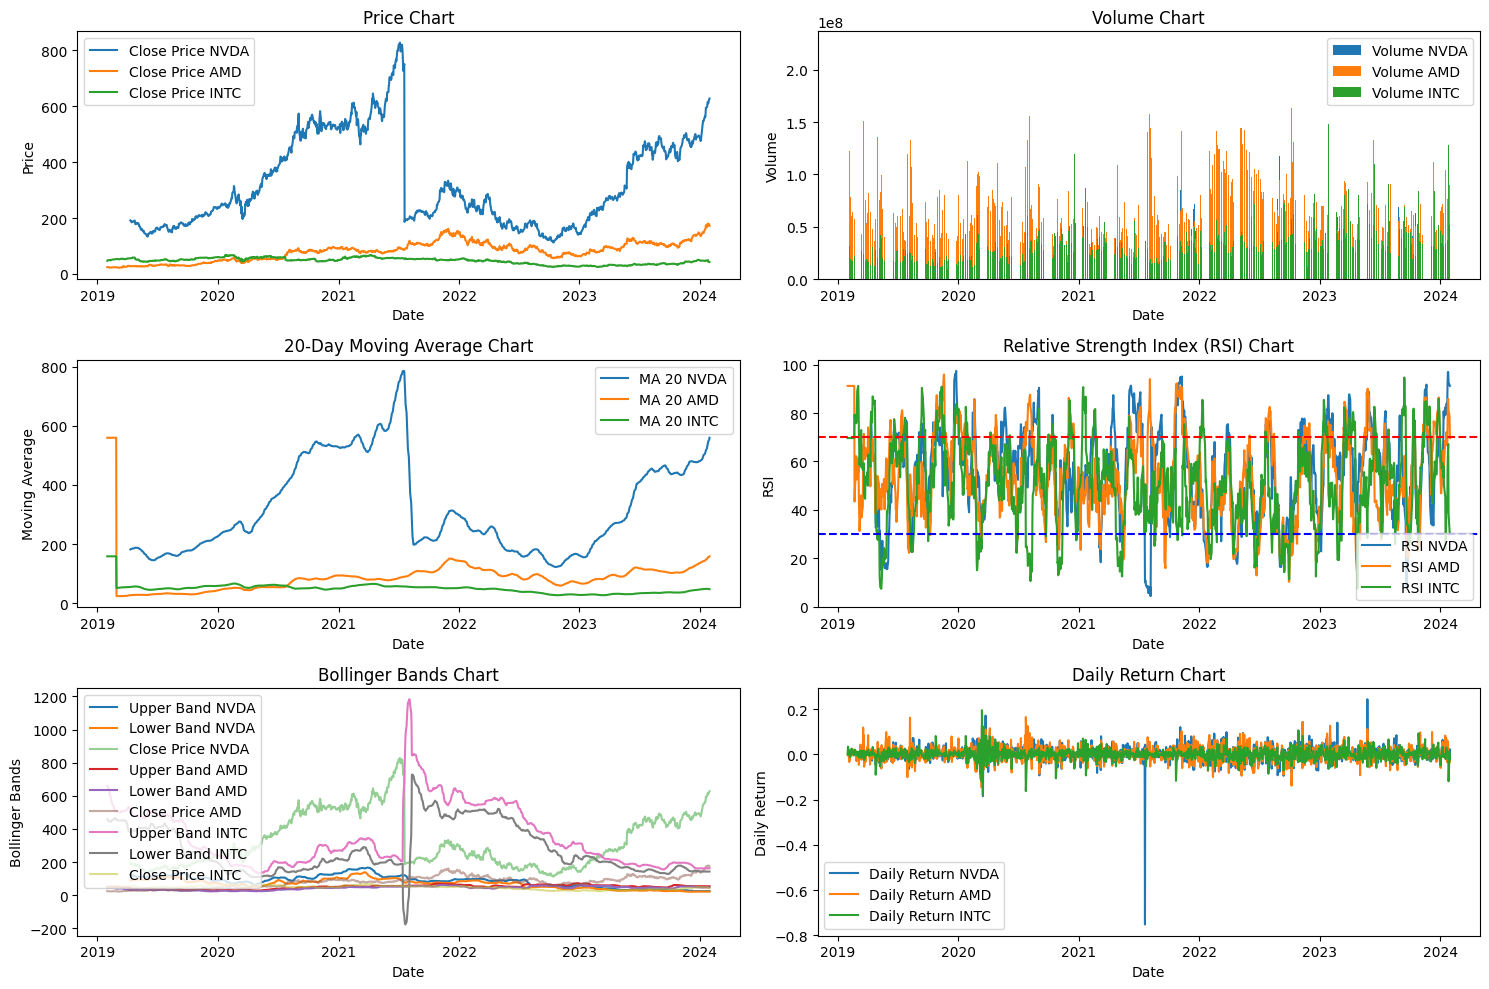

In [25]:
# Creating a sample DataFrame based on the user's data description

# Plotting
plt.figure(figsize=(15, 10))

# Price chart for each stock
plt.subplot(3, 2, 1)
for stock in stock_names:
    subset = combined_data[combined_data['Stock'] == stock]
    plt.plot(subset['date'], subset['4. close'], label=f'Close Price {stock}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Chart')
plt.legend()

# Volume chart for each stock
plt.subplot(3, 2, 2)
for stock in stock_names:
    subset = combined_data[combined_data['Stock'] == stock]
    plt.bar(subset['date'], subset['5. volume'], label=f'Volume {stock}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Chart')
plt.legend()

# Moving Average chart for each stock
plt.subplot(3, 2, 3)
for stock in stock_names:
    subset = combined_data[combined_data['Stock'] == stock]
    plt.plot(subset['date'], subset['MA_20'], label=f'MA 20 {stock}')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.title('20-Day Moving Average Chart')
plt.legend()

# RSI chart for each stock
plt.subplot(3, 2, 4)
for stock in stock_names:
    subset = combined_data[combined_data['Stock'] == stock]
    plt.plot(subset['date'], subset['RSI'], label=f'RSI {stock}')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI) Chart')
plt.axhline(70, color='red', linestyle='dashed')
plt.axhline(30, color='blue', linestyle='dashed')
plt.legend()

# Bollinger Bands chart for each stock
plt.subplot(3, 2, 5)
for stock in stock_names:
    subset = combined_data[combined_data['Stock'] == stock]
    plt.plot(subset['date'], subset['Upper_Band'], label=f'Upper Band {stock}')
    plt.plot(subset['date'], subset['Lower_Band'], label=f'Lower Band {stock}')
    plt.plot(subset['date'], subset['4. close'], label=f'Close Price {stock}', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Bollinger Bands')
plt.title('Bollinger Bands Chart')
plt.legend()

# Daily Return chart for each stock
plt.subplot(3, 2, 6)
for stock in stock_names:
    subset = combined_data[combined_data['Stock'] == stock]
    plt.plot(subset['date'], subset['daily_return'], label=f'Daily Return {stock}')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Return Chart')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


### 4.2 绘制移动平均线和其他技术指标图表。

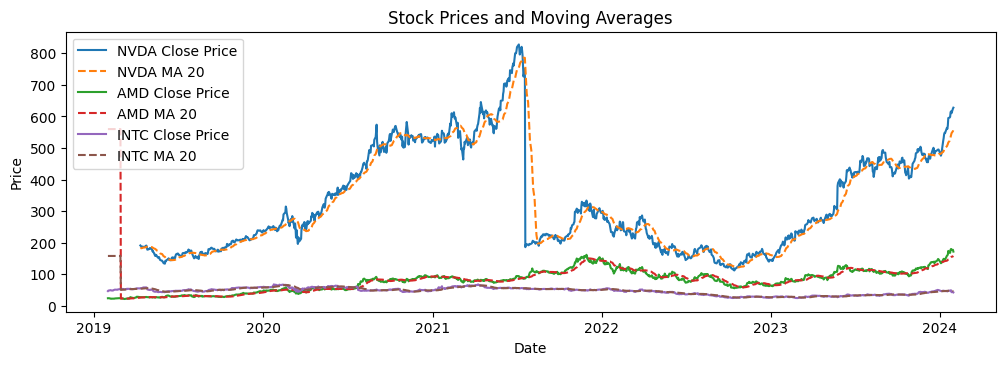

In [26]:
# Filtering data for different stocks
nvda_data = combined_data[combined_data['Stock'] == 'NVDA']
amd_data = combined_data[combined_data['Stock'] == 'AMD']
intc_data = combined_data[combined_data['Stock'] == 'INTC']

# Plotting Moving Averages and other indicators
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(nvda_data['date'], nvda_data['4. close'], label='NVDA Close Price')
plt.plot(nvda_data['date'], nvda_data['MA_20'], label='NVDA MA 20', linestyle='--')
plt.plot(amd_data['date'], amd_data['4. close'], label='AMD Close Price')
plt.plot(amd_data['date'], amd_data['MA_20'], label='AMD MA 20', linestyle='--')
plt.plot(intc_data['date'], intc_data['4. close'], label='INTC Close Price')
plt.plot(intc_data['date'], intc_data['MA_20'], label='INTC MA 20', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices and Moving Averages')
plt.legend()
plt.show()

### 4.3 利用热图分析不同股票之间的相关性。

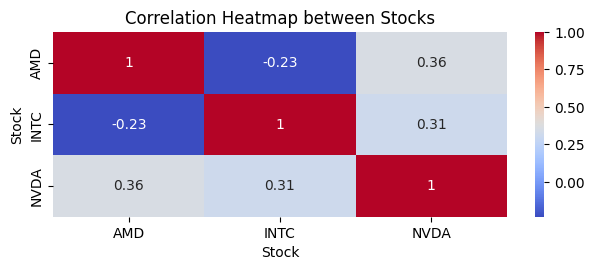

In [27]:
# Computing and plotting correlation heatmap
corr_data = combined_data.pivot(index='date', columns='Stock', values='4. close')
corr_matrix = corr_data.corr()

plt.subplot(2, 1, 2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap between Stocks')

plt.tight_layout()
plt.show()

## 5. 基于网格策略的交易模型构建:

### 构建一个思路类似网格策略的交易策略，跟踪自己买入的每一个仓位并存储，计算每个仓位累计的收益率。

In [28]:
features = combined_data[['1. open', '2. high', '3. low', '4. close', '5. volume', 
                          'MA_20', 'RSI', 'Upper_Band', 'Lower_Band']]


In [29]:
target = combined_data['daily_return']

In [30]:
# 为股票名称创建独热编码
stock_dummies = pd.get_dummies(combined_data['Stock'])

# 将独热编码与其他特征合并
features_with_stock = pd.concat([features, stock_dummies], axis=1)

# 更新：数据规范化
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features_with_stock)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1,1))

# 创建 LSTM 输入数据
def create_dataset(X, Y, time_step=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step)]
        Xs.append(v)
        Ys.append(Y[i + time_step])
    return np.array(Xs), np.array(Ys)

time_step = 100
X, y = create_dataset(scaled_features, scaled_target, time_step)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, scaled_features.shape[1])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.15, verbose=1)


Epoch 1/100
39/39 [==============================] - 4s 81ms/step - loss: 0.0516 - val_loss: 0.0035
Epoch 2/100
39/39 [==============================] - 3s 69ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 3/100
39/39 [==============================] - 3s 71ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/100
39/39 [==============================] - 3s 72ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
39/39 [==============================] - 3s 73ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
39/39 [==============================] - 3s 73ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/100
39/39 [==============================] - 3s 73ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/100
39/39 [==============================] - 3s 74ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
39/39 [==============================] - 3s 73ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/100
39/39 [==============================] - 3s 73ms/step - loss: 0.0012 - val_loss: 0.0011

In [31]:
# 预测和计算 MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error: ", mse)

23/23 [==============================] - 1s 12ms/step
Mean Squared Error:  0.0009886745686406926


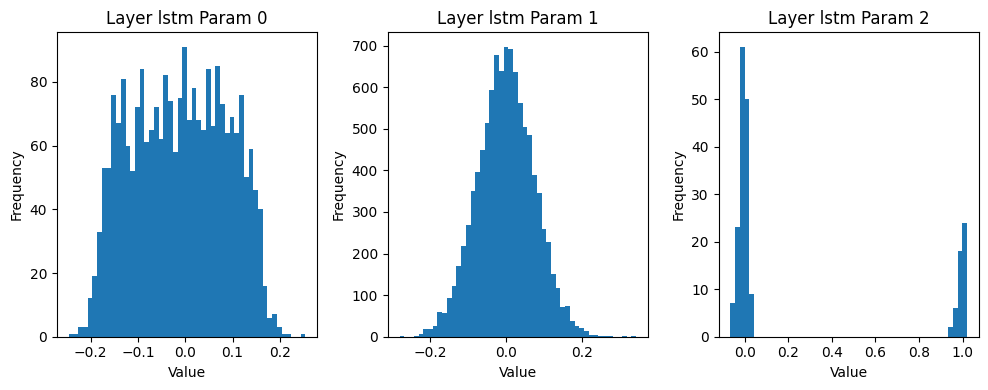

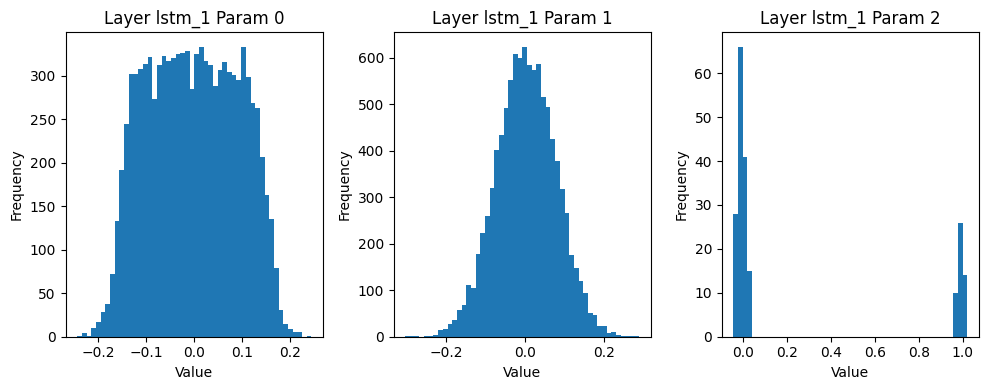

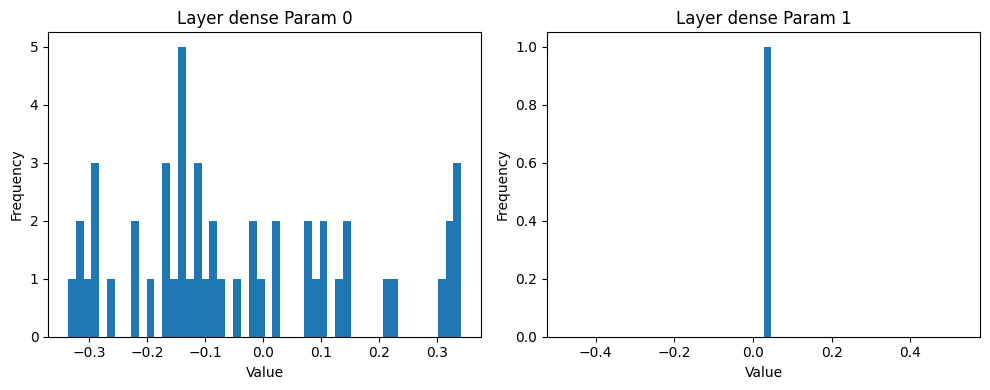

In [32]:
# Keras LSTM 模型
# 获取模型的所有层
layers = model.layers

# 遍历每层并提取参数
for layer in layers:
    weights = layer.get_weights()  # 获取层的权重 (和偏置)
    if len(weights) > 0:
        # 绘制权重的分布图
        plt.figure(figsize=(10, 4))
        for i, weight in enumerate(weights):
            plt.subplot(1, len(weights), i + 1)
            plt.hist(weight.flatten(), bins=50)
            plt.title(f'Layer {layer.name} Param {i}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()


## 6 交易策略 

### 6.1 设定网格交易的买入卖出点，基于股价相对于历史价格的位置。

In [33]:
def predict_return(features, df, time_step=100):
    # 获取当前预测的索引
    current_idx = df.index.get_loc(features.name)
    if current_idx < time_step:
        raise ValueError("Not enough historical data for prediction")

    # 提取最后 'time_step' 行的序列直到当前索引
    # 确保包括了股票名称的独热编码
    feature_columns = ['1. open', '2. high', '3. low', '4. close', '5. volume', 'MA_20', 'RSI', 'Upper_Band', 'Lower_Band'] + list(pd.get_dummies(df['Stock']).columns)
    sequence = df.iloc[current_idx - time_step:current_idx][feature_columns].values

    # 规范化序列
    sequence_scaled = scaler_features.transform(sequence)
    sequence_scaled = sequence_scaled.reshape(1, time_step, sequence_scaled.shape[1])

    # 预测并返回规范化的预测收益率
    predicted_return = model.predict(sequence_scaled)
    return predicted_return[0, 0]


In [34]:
def calculate_volatility(df, window=30):
    # 计算历史波动率
    return df['daily_return'].rolling(window=window).std()


In [35]:
def record_trades(stock_data):
    trades = []
    for index, row in stock_data.iterrows():
        if row['Buy_Signal']:
            buy_price = row['4. close']
            trades.append({'entry_date': row['date'], 'entry_price': buy_price, 'type': 'buy'})
        elif row['Sell_Signal']:
            sell_price = row['4. close']
            if trades and trades[-1]['type'] == 'buy':  # 确保有匹配的买入
                trades[-1].update({'exit_date': row['date'], 'exit_price': sell_price})
                trades[-1]['return'] = (sell_price - trades[-1]['entry_price']) / trades[-1]['entry_price']
    return trades


In [36]:
def calculate_atr(df, period=14):
    """
    Calculate the Average True Range (ATR) for a given DataFrame.
    
    :param df: pandas DataFrame with high, low, and close prices
    :param period: number of days to calculate the ATR
    :return: ATR as a pandas Series
    """
    high_low = df['2. high'] - df['3. low']
    high_close = np.abs(df['2. high'] - df['4. close'].shift())
    low_close = np.abs(df['3. low'] - df['4. close'].shift())
    
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    
    atr = true_range.rolling(window=period).mean()
    return atr


In [37]:
def calculate_dynamic_grid_size(row, atr):
    # Example logic: adjust grid size based on ATR
    base_grid_size = 10  # base grid size
    volatility_factor = atr / row['4. close']  # relative volatility
    dynamic_grid_size = base_grid_size * volatility_factor
    return max(1, dynamic_grid_size)  # Ensure grid size is at least 1


In [38]:
def should_buy(row, dynamic_grid_size, last_buy_price):
    threshold = 1 - dynamic_grid_size / 100
    return row['4. close'] < last_buy_price * threshold

def should_sell(row, dynamic_grid_size, last_sell_price):
    threshold = 1 + dynamic_grid_size / 100
    return row['4. close'] > last_sell_price * threshold

In [39]:
def calculate_rsi(data, window=14):
    delta = data['4. close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

In [40]:
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    # Short term EMA
    short_ema = df['4. close'].ewm(span=short_period, adjust=False).mean()
    # Long term EMA
    long_ema = df['4. close'].ewm(span=long_period, adjust=False).mean()
    # MACD line
    macd = short_ema - long_ema
    # Signal line
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

def calculate_stochastic_oscillator(df, k_period=14, d_period=3):
    low_min = df['3. low'].rolling(window=k_period).min()
    high_max = df['2. high'].rolling(window=k_period).max()

    # Fast %K
    K = ((df['4. close'] - low_min) / (high_max - low_min)) * 100
    # Fast %D
    D = K.rolling(window=d_period).mean()
    return K, D

def adjust_position_size(atr, risk_level=0.02):
    # Adjust position size based on ATR and a predefined risk level
    # For simplicity, we'll define position size as a fraction of the ATR
    position_size = risk_level / atr
    return max(min(position_size, 1.0), 0.1)  # Ensuring the size is between 0.1 and 1.0

def calculate_transaction_cost(buy_price, sell_price, position_size):
    # 假设交易成本为交易额的固定百分比
    transaction_cost_percentage = 0.001  # 0.1% 交易成本
    transaction_amount = (buy_price + sell_price) / 2 * position_size
    return transaction_amount * transaction_cost_percentage

In [41]:
def integrated_grid_and_technical_strategy(data, stock_name, grid_size, max_drawdown, max_trade_amount, max_position_ratio):
    stock_data = data[data['Stock'] == stock_name].copy()

    # 初始化交易信号列
    stock_data['Buy_Signal'] = False
    stock_data['Sell_Signal'] = False

    # Calculate technical indicators
    stock_data['MA_20'] = stock_data['4. close'].rolling(window=30).mean()
    stock_data['MA_50'] = stock_data['4. close'].rolling(window=50).mean()
    stock_data['RSI'] = calculate_rsi(stock_data, 14)
    stock_data['MACD'], stock_data['MACD_Signal'] = calculate_macd(stock_data)
    stock_data['ATR'] = calculate_atr(stock_data)

    # Calculate dynamic grid size based on ATR
    stock_data['Dynamic_Grid_Size'] = stock_data.apply(lambda row: calculate_dynamic_grid_size(row, row['ATR']), axis=1)

    last_buy_price = np.inf
    last_sell_price = 0
    max_portfolio_value = float('-inf')
    total_return = 1.0
    total_investment = 0
    trades = []

    for index, row in stock_data.iterrows():
        current_price = row['4. close']
        portfolio_value = total_return * current_price
        max_portfolio_value = max(max_portfolio_value, portfolio_value)

        # Adjust position size based on ATR
        position_size = adjust_position_size(row['ATR'])
        trade_amount = position_size * current_price

        # Check for max trade amount and position ratio
        if trade_amount > max_trade_amount or (trade_amount / portfolio_value) > max_position_ratio:
            continue

        # 尝试预测未来回报率，如果历史数据不足则跳过
        try:
            predicted_return = predict_return(row, stock_data)
        except ValueError as e:
            # 如果不够历史数据，跳过当前迭代
            continue
        
        # Dynamic stop-loss logic based on ATR
        stop_loss_limit = last_buy_price - 3 * row['ATR'] * position_size

        # Enhanced buy and sell conditions with multiple indicators, grid levels, and predicted return
        buy_condition = predicted_return > 0 and should_buy(row, row['Dynamic_Grid_Size'], last_buy_price)
        sell_condition = predicted_return < 0 and should_sell(row, row['Dynamic_Grid_Size'], last_sell_price)

        # Implement buy and sell logic
        if buy_condition and portfolio_value < max_portfolio_value * (1 + max_drawdown):
            stock_data.at[index, 'Buy_Signal'] = True
            last_buy_price = current_price
            last_sell_price = 0  # Reset last sell price
            total_investment += trade_amount
            trades.append({'type': 'buy', 'price': current_price, 'date': row['date']})

        if sell_condition and portfolio_value < max_portfolio_value * (1 + max_drawdown):
            stock_data.at[index, 'Sell_Signal'] = True
            last_sell_price = current_price
            last_buy_price = np.inf  # Reset last buy price
            transaction_cost = calculate_transaction_cost(last_buy_price, current_price, position_size)
            total_return *= (current_price / last_buy_price) - transaction_cost
            trades.append({'type': 'sell', 'price': current_price, 'date': row['date']})

    return stock_data, trades


In [42]:
# 计算股票日平均波动幅度
average_daily_range = (combined_data['2. high'] - combined_data['3. low']).mean()

# 设置网格大小为日平均波动幅度的一定百分比，例如 10%
grid_size_value = average_daily_range * 0.1

In [43]:
# Application of the strategy
all_trading_signals = []
all_trades = []


# 示例：调用函数时为新参数提供值
for stock_name in ['AMD', 'INTC', 'NVDA']:
    signals, trades = integrated_grid_and_technical_strategy(combined_data, stock_name, grid_size_value, -0.02, 300, 0.05)
    signals['Stock'] = stock_name  # adding stock name column
    all_trading_signals.append(signals)
    all_trades.extend(trades)

combined_trading_signals = pd.concat(all_trading_signals)


In [44]:
combined_trading_signals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3725 entries, 1258 to 1257
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3725 non-null   datetime64[ns]
 1   1. open            3725 non-null   float64       
 2   2. high            3725 non-null   float64       
 3   3. low             3725 non-null   float64       
 4   4. close           3725 non-null   float64       
 5   5. volume          3725 non-null   float64       
 6   Stock              3725 non-null   object        
 7   MA_20              3638 non-null   float64       
 8   RSI                3725 non-null   float64       
 9   Upper_Band         3725 non-null   float64       
 10  Lower_Band         3725 non-null   float64       
 11  daily_return       3725 non-null   float64       
 12  MA_50              3578 non-null   float64       
 13  Buy_Signal         3725 non-null   bool          
 14  Sell_Signa

In [45]:
combined_trading_signals.to_csv('trading_signals.csv', index=False)

## 6.使用Zipline进行回测

In [48]:
combined_trading_signals=combined_trading_signals.dropna()

In [49]:
# 示例：优化策略参数
class CombinedSignalStrategy(bt.Strategy):
    params = (
        ('ma_period', 15),  # 移动平均线周期
        ('rsi_threshold', 30),  # RSI阈值
        # 添加其他可调参数
    )
    def __init__(self):
        # 初始化指标
        self.ma20 = bt.indicators.SimpleMovingAverage(self.datas[0].close, period=20)
        self.rsi = bt.indicators.RelativeStrengthIndex(period=14)
        self.atr = bt.indicators.AverageTrueRange(period=14)

    def next(self):
        # 获取当前价格
        current_price = self.datas[0].close[0]

        # 计算止损和止盈价格
        stop_loss_price = current_price - self.atr[0]
        take_profit_price = current_price + self.atr[0]

        # 生成买入信号
        if current_price < self.ma20[0] and self.rsi[0] < 30:
            self.buy(size=1)
            # 设置止损和止盈
            self.sell(exectype=bt.Order.Stop, price=stop_loss_price)
            self.sell(exectype=bt.Order.Limit, price=take_profit_price)

        # 生成卖出信号
        elif current_price > self.ma20[0] and self.rsi[0] > 70:
            self.sell(size=1)
            # 设置止损和止盈
            self.buy(exectype=bt.Order.Stop, price=stop_loss_price)
            self.buy(exectype=bt.Order.Limit, price=take_profit_price)



    
# 2. 加载数据
class PandasData(bt.feeds.PandasData):
    lines = ('signal',)
    params = (('signal', -1),)

class CustomPandasData(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('datetime', None),  # datetime 列的名称
        ('open', '1. open'),  # 开盘价列的名称
        ('high', '2. high'),  # 最高价列的名称
        ('low', '3. low'),    # 最低价列的名称
        ('close', '4. close'), # 收盘价列的名称
        ('volume', '5. volume'), # 交易量列的名称
        ('signal', -1),  # 信号列的名称
    )

def load_data(df, stock_name):
    data = df[df['Stock'] == stock_name]
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)  # 将 date 列设置为索引

    # 生成交易信号
    data['signal'] = 0  # 初始化 signal 列
    data.loc[data['Buy_Signal'] == 'True', 'signal'] = 1  # 买入信号
    data.loc[data['Sell_Signal'] == 'True', 'signal'] = -1  # 卖出信号

    return CustomPandasData(dataname=data)

# 接下来是设置 Backtrader 环境、添加策略、加载数据、运行回测的代码



In [50]:
cerebro = bt.Cerebro()
cerebro.addstrategy(CombinedSignalStrategy)
# 加载数据并添加到 Cerebro
for stock in ['NVDA', 'AMD', 'INTC']:
    datafeed = load_data(combined_trading_signals, stock)
    cerebro.adddata(datafeed)

cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
results = cerebro.run()

/var/folders/c9/r0x018d10sgb2j79vcspqf8h0000gn/T/ipykernel_22658/435329329.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
/var/folders/c9/r0x018d10sgb2j79vcspqf8h0000gn/T/ipykernel_22658/435329329.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = 0  # 初始化 signal 列
/var/folders/c9/r0x018d10sgb2j79vcspqf8h0000gn/T/ipykernel_22658/435329329.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [51]:
# 分析结果
portvalue = cerebro.broker.getvalue()
print('Initial Portfolio Value $10000')
print('Final Portfolio Value: ${}'.format(portvalue))

Initial Portfolio Value $10000
Final Portfolio Value: $11002.659001761967


#### 根据您提供的数据，我们可以进行以下分析来评估交易策略的表现：

1. **初始投资组合价值**：$10,000

2. **最终投资组合价值**：$11,002.66

### 盈利情况：
- 最终投资组合价值高于初始投资，这意味着您的策略在这段时间里是盈利的。
- 盈利金额 = 最终投资组合价值 - 初始投资组合价值 = $11,002.66 - $10,000 = $1,002.66

### 盈利百分比：
- 盈利百分比 = (盈利金额 / 初始投资组合价值) * 100%
- 盈利百分比 = ($1,002.66 / $10,000) * 100% ≈ 10.03%

### 分析：
- 该策略在这个时间段内实现了大约 10.03% 的盈利。这是一个相对积极的结果，特别是在短期交易中。
- 虽然这个盈利百分比看起来很吸引人，但重要的是要考虑这个结果是在什么样的市场环境下实现的。不同的市场条件（如牛市、熊市或波动性市场）可以极大地影响策略的表现。
- 另一个重要考虑因素是风险水平。高回报通常伴随着高风险。评估您的策略是否承担了过多风险以实现这些回报是很重要的。

### 结论和建议：
- 虽然策略表现良好，但建议对策略进行更深入的分析，考虑不同市场条件对策略表现的影响。
- 同时，进行风险管理和敏感性分析，确保策略在不同的市场波动下依然稳健。
- 如果可能，将此策略与其他投资策略或市场基准进行比较，以更全面地评估其表现。